### data0 - all car images, including whole and damaged

In [1]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import json
import pickle as pk
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import os
import h5py
import numpy as np
import pandas as pd

from keras.utils.data_utils import get_file
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History

Using TensorFlow backend.


In [3]:
CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

In [4]:
# from Keras GitHub  
def get_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',
                         CLASS_INDEX_PATH,
                         cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

In [5]:
# download pretrained VGG16 model from keras
vgg16 = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 392s 1us/step


In [6]:
# save the model
vgg16.save('E:/pg/docs/Car Detection/dataset/car-damage-detective-master/app/static/models/vgg16.h5')

In [7]:
# download others pretrained models from keras for comparison
resnet50 = ResNet50(weights='imagenet')
vgg19 = VGG19(weights='imagenet')
inception = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 79s 1us/step


In [ ]:
# save the model
resnet50.save('E:/pg/docs/Car Detection/dataset/car-damage-detective-master/app/static/models/resnet50.h5')
vgg19.save('E:/pg/docs/Car Detection/dataset/car-damage-detective-master/app/static/models/vgg19.h5')
inception.save('E:/pg/docs/Car Detection/dataset/car-damage-detective-master/app/static/models/inception.h5')

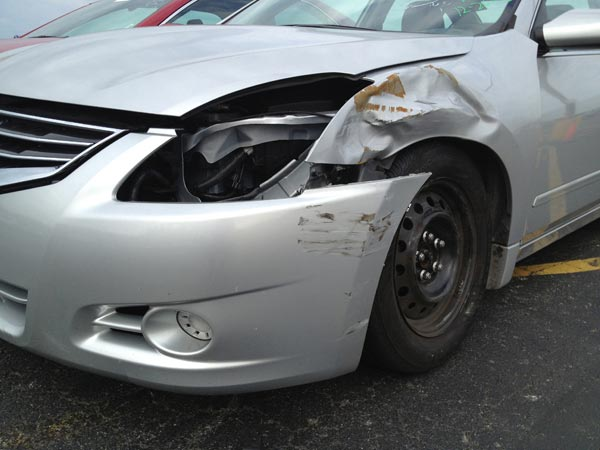

In [26]:
Image('C:/Users/prateek1.gupta/Desktop/California-Sell-Damaged-Car.jpg', width=300)

In [15]:
def prepare_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

## Testing with different models

In [12]:
y = prepare_image('C:/Users/prateek1.gupta/Desktop/California-Sell-Damaged-Car.jpg')
preds = vgg16.predict(y)
print(get_predictions(preds, top=5))

40960/35363 [==================================] - 0s 7us/step
[[('n03770679', 'minivan', 0.23611392), ('n03100240', 'convertible', 0.22538722), ('n04285008', 'sports_car', 0.12007795), ('n02814533', 'beach_wagon', 0.110845834), ('n03670208', 'limousine', 0.07069266)]]


In [18]:
#z = preprocess_input(x)
z = prepare_image('C:/Users/prateek1.gupta/Desktop/California-Sell-Damaged-Car.jpg')
preds = resnet50.predict(z)
print(get_predictions(preds))

[[('n04285008', 'sports_car', 0.25801325), ('n02974003', 'car_wheel', 0.1864414), ('n03770679', 'minivan', 0.14004585), ('n03670208', 'limousine', 0.11042896), ('n02930766', 'cab', 0.06389718)]]


In [20]:
#a = preprocess_input(x)
a = prepare_image('C:/Users/prateek1.gupta/Desktop/California-Sell-Damaged-Car.jpg')
preds = vgg19.predict(a)
print(get_predictions(preds))

[[('n03770679', 'minivan', 0.21274005), ('n03100240', 'convertible', 0.16966033), ('n04285008', 'sports_car', 0.14670421), ('n02814533', 'beach_wagon', 0.104222305), ('n03459775', 'grille', 0.09352197)]]


## Using VGG16 as Gate

In [29]:
def get_car_categories():
    d = defaultdict(float)
    img_list = os.listdir('E:/pg/docs/Car Detection/dataset/car-damage-dataset.tar/data1a/training/00-damage')
    for i, img_path in enumerate(img_list):
        img = prepare_image('E:/pg/docs/Car Detection/dataset/car-damage-dataset.tar/data1a/training/00-damage/'+img_path)
        out = vgg16.predict(img)
        top = get_predictions(out, top=5)
        for j in top[0]:
            d[j[0:2]] += j[2]
        if i % 50 == 0:
            print(i, '/', len(img_list), 'complete')
    return Counter(d)

In [30]:
cat_counter = get_car_categories()

0 / 920 complete
50 / 920 complete
100 / 920 complete
150 / 920 complete
200 / 920 complete
250 / 920 complete
300 / 920 complete
350 / 920 complete
400 / 920 complete
450 / 920 complete
500 / 920 complete
550 / 920 complete
600 / 920 complete
650 / 920 complete
700 / 920 complete
750 / 920 complete
800 / 920 complete
850 / 920 complete
900 / 920 complete


In [31]:
with open('cat_counter.pk', 'wb') as f:
    pk.dump(cat_counter,f,-1)

### Load Pickle Point

In [32]:
with open('cat_counter.pk', 'rb') as f:
    cat_counter = pk.load(f)

In [33]:
cat_list = [k for k, v in cat_counter.most_common()[:50]]

## Evaluating Car Categories from Imagenet

In [39]:
def get_car_categories(cat_list):
    img_list = os.listdir('E:/pg/docs/Car Detection/dataset/car-damage-dataset.tar/data1a/training/00-damage')
    num = 0
    bad_list = []
    for i, img_path in enumerate(img_list):
        img = prepare_image('E:/pg/docs/Car Detection/dataset/car-damage-dataset.tar/data1a/training/00-damage/'+img_path)
        out = vgg16.predict(img)
        top = get_predictions(out, top=5)
        for j in top[0]:
            if j[0:2] in cat_list:
                num += 1
                break # breaks out of for loop if one of top 50 categories is found
            else:
                pass
            bad_list.append(img_path) # appends to "bad list" if none of the 50 are found
        if i % 100 == 0:
            print(i, '/', len(img_list), 'complete')
    bad_list = [k for k, v in Counter(bad_list).items() if v == 5]
    return num, bad_list

In [40]:
number, bad_list = get_car_categories(cat_list)

0 / 920 complete
100 / 920 complete
200 / 920 complete
300 / 920 complete
400 / 920 complete
500 / 920 complete
600 / 920 complete
700 / 920 complete
800 / 920 complete
900 / 920 complete


In [42]:
#number2, bad_list2 = car_categories_gate(cat_list2)

NameError: name 'cat_list2' is not defined

In [212]:
number2, bad_list2 = car_categories_gate(cat_list2)

2

## Select top 50 as cutoff for category list

In [45]:
def view_images(img_dir, img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img))
        num = input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

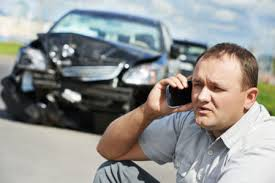

c to continue, q to quitq


'Finished for now.'

In [46]:
view_images('E:/pg/docs/Car Detection/dataset/car-damage-dataset.tar/data1a/training/00-damage/', bad_list)

In [47]:
#view_images('E:/pg/docs/Car Detection/dataset/car-damage-dataset.tar/data1a/training/00-damage/', bad_list2)

NameError: name 'bad_list2' is not defined

## Gate Implementation

In [51]:
import urllib.request
def car_categories_gate(image_path, cat_list):
    urllib.request.urlretrieve(image_path, 'save.jpg') # or other way to upload image
    img = prepare_image('save.jpg')
    out = vgg16.predict(img)
    top = get_predictions(out, top=5)
    print("Validating that this is a picture of your car...")
    for j in top[0]:
        if j[0:2] in cat_list:
            print(j[0:2])
            return "Validation complete - proceed to damage evaluation"
    return "Are you sure this is a picture of your car? Please take another picture (try a different angle or lighting) and try again."

In [52]:
car_categories_gate('https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcSxhKhaSwPgdQkrDegC6sbUALBF9SiW6tDKg6dLDYj83e19krxy', cat_list)

Validating that this is a picture of your car...
('n02930766', 'cab')


'Validation complete - proceed to damage evaluation'

In [53]:
car_categories_gate('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7xHO3j12Xk4q4eaQUL1A02k1HrJ9G_RY6tj-4h-07EfdML6YL', cat_list)

Validating that this is a picture of your car...
('n02747177', 'ashcan')


'Validation complete - proceed to damage evaluation'